[2017-07-27 08:57:26,490] Making new env: CartPole-v0


Episode: 99, Mean reward: 9
Episode: 199, Mean reward: 31
Episode: 299, Mean reward: 89
Episode: 399, Mean reward: 122
Mean reward:  88.1131687243
Max 100 rewards mean:  199.24
Max 100 rewards from episode: 386, to episode: 485


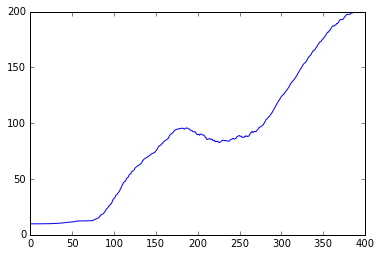

Play 20 times with optimal policy
Iteration: 0, Total Reward: 200
Iteration: 1, Total Reward: 200
Iteration: 2, Total Reward: 200
Iteration: 3, Total Reward: 200
Iteration: 4, Total Reward: 200
Iteration: 5, Total Reward: 200
Iteration: 6, Total Reward: 200
Iteration: 7, Total Reward: 200
Iteration: 8, Total Reward: 200
Iteration: 9, Total Reward: 200
Iteration: 10, Total Reward: 200
Iteration: 11, Total Reward: 200
Iteration: 12, Total Reward: 200
Iteration: 13, Total Reward: 200
Iteration: 14, Total Reward: 200
Iteration: 15, Total Reward: 200
Iteration: 16, Total Reward: 200
Iteration: 17, Total Reward: 200
Iteration: 18, Total Reward: 200
Iteration: 19, Total Reward: 200


In [1]:
import numpy as np
import tensorflow as tf
import gym
import random
import matplotlib.pyplot as plt
from collections import deque

%matplotlib inline

env = gym.make('CartPole-v0')
max_num_episodes = 2000
checkpoint = 100
replay_experience_maxlen = 50000
batch_size = 64

learning_rate = 0.001
decay = 0.99

tf.reset_default_graph()
X = tf.placeholder(dtype=tf.float32, shape=(None, 4))
y = tf.placeholder(dtype=tf.float32, shape=(None, 2))
net = tf.contrib.layers.fully_connected(X, 15)
Q = tf.contrib.layers.fully_connected(net, 2, activation_fn=None)
mse = tf.contrib.losses.mean_squared_error(y, Q)
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mse)

all_rewards = []

def stats(rewards):
    print("Mean reward: ", np.mean(rewards))
    rewards_100 = []
    for i in range(100, len(rewards) + 1):
        rewards_100.append(np.mean(rewards[i-100:i]))
    print("Max 100 rewards mean: ", np.max(rewards_100))
    re = np.argmax(rewards_100)
    print("Max 100 rewards from episode: %d, to episode: %d" % (re, re + 99))
    plt.plot(rewards_100)
    plt.show()

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# Initialize empty experiences
replay_experience = deque(maxlen=replay_experience_maxlen)
for episode in range(max_num_episodes):
    state = env.reset()
    epsilon = 1./((episode/50) + 10)
    done = False
    episode_reward = 0
    while not done:
        # Calculate Q(s, a) for all a
        Q_s_A = Q.eval(feed_dict={X: state.reshape((1, 4))})
        
        # Choose action based on epsilon-greedy policy
        if np.random.random_sample() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_s_A[0])

        # Perform action
        next_state, reward, done, _ = env.step(action)

        # Append final reward for each episode
        episode_reward += reward

        # Change 0 reward to -1 to learn more from punishment
        if done:
            reward = -1.0

        # Save experience
        replay_experience.append([state, action, reward, next_state, done])

        # Switch to next state
        state = next_state
        
        # Do training if replay_experience contains enough sample > batch_size
        if len(replay_experience) > batch_size:
            ## 1- Sample from replay experience
            batch = random.sample(replay_experience, batch_size)
            states = np.vstack([x[0] for x in batch])
            actions = np.array([x[1] for x in batch])
            rewards = np.array([x[2] for x in batch])
            next_states = np.vstack([x[3] for x in batch])
            episodes_done = np.array([x[4] for x in batch])
            target_Q = Q.eval(feed_dict={X: states})
            target_Q[range(batch_size), actions] = rewards + decay * np.max(Q.eval(feed_dict={X: next_states}), axis=1) * ~episodes_done
            train_step.run(feed_dict={X: states, y: target_Q})
            
    if (episode + 1) % checkpoint == 0:
        print("Episode: %d, Mean reward: %d" % (episode, np.mean(all_rewards[-100:])))
    
    all_rewards.append(episode_reward)
    
    if np.mean(all_rewards[-100:]) > 199:
        break

stats(all_rewards)

print("Play 20 times with optimal policy")
for i in range(20):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state, reward, done, _ = env.step(np.argmax(Q.eval(feed_dict={X: state.reshape((1, 4))})))
        total_reward += reward
        env.render()
    print("Iteration: %d, Total Reward: %d" % (i, total_reward))

sess.close()
env.close()